In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, Normalize, Compose


transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
fdataset = FashionMNIST(root="./data", train=True, download=True, transform=transform)
data = DataLoader(fdataset, batch_size=64, shuffle=True, num_workers=2)

images, labels = next(iter(data))
print(f"{images.shape=} {labels.shape=}")

images.shape=torch.Size([64, 1, 28, 28]) labels.shape=torch.Size([64])


In [2]:
# import torch.nn as nn
# import torch.nn.functional as F 

# class Network(nn.Module):
#   def __init__(self):
#     self.fc = nn.Linear(784 , 64)
#     self.output = nn.Linear(64 , 784) 

#   def forward(self , x):
#     x = torch.flatten(x , dim = 1)
#     x = F.sigmoid(self.output(F.relu(self.fc(x))))
#     return x

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = Network().to(device) 

# num_epochs = 5
# learning_rate = 1e-3
# optimizer = torch.optim.Adam(model.parameters() , lr = learning_rate) 
# criterion = nn.MSE()

# for epoch in range(num_epochs):
#   for i,batch in enumerate(dataloader) : 
#     images , labels = batch 
#     images = images.to(device) 

#     outputs = model(images) 
#     loss = criterion(outputs , torch.flatten(images , 1)) 
#     loss.backward() 

#     optimizer.step()
#     optimizer.zero_grad() 

#     if(i<10):
#       print(f'{epoch} , {i} : {loss}')

In [3]:
import torch 
import torch.nn.functional as F 
import torch.nn as nn 
from torch.optim import Adam 

In [4]:
# VARIATIONAL AUTOENCODERS 

class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() 
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [55]:
learning_rate = 1e-3
criterion =  nn.MSELoss() 

def train(autoencoder, data, epochs=4):
    opt = torch.optim.Adam(autoencoder.parameters() , lr = learning_rate)
    for epoch in range(epochs):
        for i,(x, y) in enumerate(data):
            x = x.to(device) # GPU
            opt.zero_grad()

            x_hat = autoencoder(x)
            loss = ((x-x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()

            opt.step()
            print(f'{epoch} , {i} : {loss}')
    return autoencoder

In [ ]:
model = Autoencoder(2).to(device)

model = train(model , data)

In [47]:
# import numpy as np

# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE 
# pca = PCA(n_components=2)
# sne = TSNE(n_components = 2)

In [57]:
import matplotlib.pyplot as plt 
import numpy as np

def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        #z = sne.fit_transform(z)
        plt.scatter(z[:,0] , z[:,1] , c = y , cmap = 'tab10') 
        if i > num_batches:
            plt.colorbar()
            break

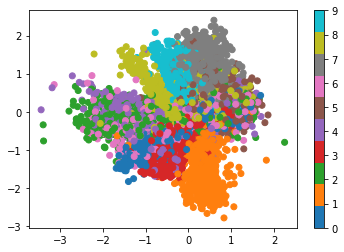

In [58]:
plot_latent(model , data)

In the above plot it is clear that the encoder outputs are clearly able to classify some of the classes from others.

Some of the clearly seens are -  

1.  class-1 (Orange-coloured points) are clearly separable 
2.   class - 2 (Blue-coloured points ) are clearly   separable , etc. 

In [59]:
import numpy as np 

def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10 , 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

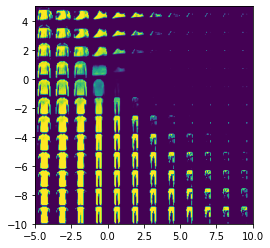

In [60]:
plot_reconstructed(model)

Encoder output vector is of length 2 . This makes it more and easy to interpret. 

In the above plot it can be seen that - 


1.   For negative x and negative y , we are getting t-shirts 
2.   For positive x and negative y , we are getting jeans 
3.   For positive x and positive y , we are getting shoes 



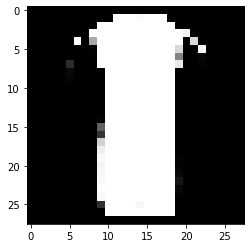

In [76]:
x = -2.5
y = -8

z = torch.tensor([x,y]).to(device) 
x_hat = model.decoder(z.float())
x_hat = x_hat.reshape(28,28).to('cpu').detach().numpy()  

plt.imshow(x_hat , cmap = 'gray')

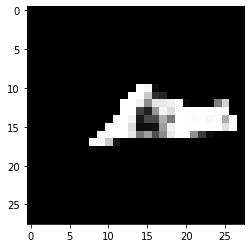

In [69]:
x = 4
y = 8

z = torch.tensor([x,y]).to(device) 
x_hat = model.decoder(z.float())
x_hat = x_hat.reshape(28,28).to('cpu').detach().numpy()  

plt.imshow(x_hat , cmap = 'gray')